<a id="top"></a>
# MAST'S View of the Sky
***
## Learning Goals

By the end of this tutorial, you will:

- Create a visualization of the MAST archive and the data it contains
- Learn about some of the different missions with data hosted at MAST and what their footprints look like
- Understand how to convert between celestial coordinates (RA, Dec) and other coordinate systems using astropy
- Create your own wallpaper image of MAST to use as a Desktop background!


## Table of Contents
* [Introduction](#Introduction)
* [Imports](#Imports)
* [MAST's View of the Sky](#MAST's-View-of-the-Sky)
    * [Making a Map of MAST Data](#Making-a-Map-of-MAST-Data)
    * [What am I looking at?](#What-am-I-looking-at?)
* [Projecting to Different Coordinate Systems](#Projecting-to-Different-Coordinate-Systems)
    * [Ecliptic Coordinates](#Ecliptic-Coordinates)
    * [Galactic Coordinates](#Galactic-Coordinates)
* [MAST Wallpaper Image](#MAST-Wallpaper-Image)
* [Additional Resources](#Additional-Resources)
  * [Citations](#Citations)
  * [About this Notebook](#About-this-Notebook)

# Introduction
As of July 2025, the [Mikulski Archive for Space Telescope (MAST)](https://archive.stsci.edu) contains nearly *300 million* astronomical observations from over 20 different telescope missions including the Hubble Space Telescope (HST), the James Webb Space Telescope (JWST), and the Transiting Exoplanet Survey Satellite (TESS).

That's a lot of data - but what does it look like? In this notebook, we will create a visualization of MAST data on the sky, and learn about the variety of different missions hosted at MAST!

## Imports
These are the packages we will need for this notebook:

- *numpy* to handle array functions
- *astropy.coordinates* for handling astronomical coordinates
- *astropy.units* for handling astronomical units
- *astroquery.mast* for resolving coordinates of different targets

- *matplotlib.pyplot* for plotting data
- *matplotlib.colors* for creating custom color maps
- *matplotlib.image* for plotting png image files



In [1]:
%matplotlib inline

# Imports for working with data
import numpy as np
from astropy.coordinates import SkyCoord, ICRS
from astropy import units
from astroquery.mast import Observations

# Imports for plotting images
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from matplotlib.image import imread
from matplotlib import patheffects

This cell updates some of the settings in `matplotlib` to use larger font sizes in the figures:

In [2]:
# Update Plotting Parameters
params = {
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
    "lines.linewidth": 1,
    "axes.titlesize": 18,
    "font.family": "serif",
    "font.size": 12,
}
plt.rcParams.update(params)

***

# MAST's View of the Sky

MAST is like a library - our collections are open to the public and free of cost. For both libraries and MAST, maintaining a detailed catalog that lists everything in the collection is extremely important to help people find what they are looking for. A library might catalog the book title, author's name, publishing year, and the location on the shelf for every book in its collection. At MAST, we maintain a list of the filenames, the astronomical coordinates, the exposure date, which telescope was used, and so much more, for every single file in the archive. This information is referred to as 'metadata' - important information which describes the contents of every file!

At MAST, this metadata catalog is accessible from your web browser using the [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html), in Python using [astroquery.MAST](https://astroquery.readthedocs.io/en/latest/mast/mast.html), or using the [Table Access Protocal (VO-TAP)](https://mast.stsci.edu/vo-tap/) service. With this MAST metadata catalog, we can retrieve a huge list of astronomical coordinates for every observation in MAST.

For this notebook, we did the hard work for you and have created a file named `mast_obscounts.npz` which contains the observation counts in MAST for every coordinate in the sky. This file was last updated in July 2025. 

*A Note of Caution:* We do not recommend trying to re-create this file yourself, because MAST contains A LOT of data and the large query will fill up your computer's RAM quickly. If you need to perform large queries or want a higher-resolution version of this file, please contact the [MAST Helpdesk](https://outerspace.stsci.edu/display/MASTDOCS/Archive+Support).

## Making a Map of MAST Data

The file provided with this notebook, `mast_obscounts.npz`, contains the observation counts in MAST for every coordinate in the sky. Let's open the file and view it's contents:

In [3]:
# Load in the file
mast_data = np.load("mast_obscounts.npz")

# Print file information
mast_data

NpzFile 'mast_obscounts.npz' with keys: data, ra, dec

This file has three keys: `data`, `ra`, and `dec`.

- The `data` array contains the *number of observations* in MAST for each coordinate
- The right Ascension (`ra`) and Declination (`dec`) arrays are the astronomical coordinates (in degrees) defining the grid over which the data was counted.

We we save each of these as it's own variable:

In [4]:
ra_coords = mast_data["ra"]
dec_coords = mast_data["dec"]
observation_counts = mast_data["data"]

And print some basic information about each aarray:

In [5]:
print(f"Shape of observation_counts: {observation_counts.shape}")
print(
    f"ra_coords: {np.min(ra_coords)} to {np.max(ra_coords)} deg in {len(ra_coords)} steps"
)
print(
    f"dec_coords: {np.min(dec_coords)} to {np.max(dec_coords)} deg in {len(dec_coords)} steps"
)

print(f"Total number of Observations: {np.sum(observation_counts)}")

Shape of observation_counts: (2100, 1050)
ra_coords: 0.0 to 360.0 deg in 2100 steps
dec_coords: -90.0 to 90.0 deg in 1050 steps
Total number of Observations: 287124009


This shows us that `observation_counts` is a 2D array, with a size of `(2100, 1050)`, covering the sky from 0 to 360 degrees in RA and -90 to 90 degrees in Declination!

Let's plot this data using `plt.imshow()` to see what it looks like! We will create a plot of the sky, with Right Ascension on the x-axis and Declination on the y-axis. Each pixel in the image will be colored according to the number of observations in MAST at that location.

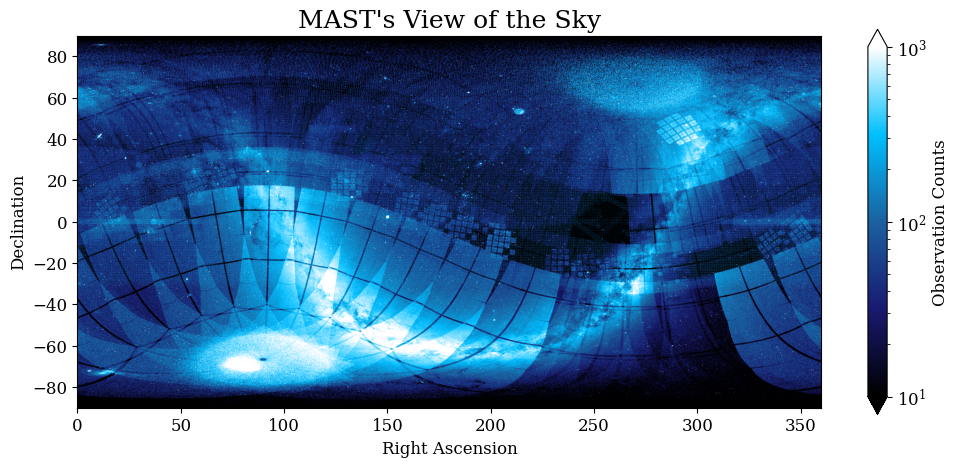

In [6]:
# Initiate plot
plt.figure(figsize=(12, 5))

# Make the background of the plot black
plt.axvspan(0, 360, color="k", zorder=-1)

# Define a custom color map
# This will create a gradient from black to blue to white!
colormap = LinearSegmentedColormap.from_list(
    "", ["black", "midnightblue", "#1a619f", "deepskyblue", "white"]
)

# Plot the data
im = plt.imshow(
    observation_counts.T,
    cmap=colormap,  # Set colormap
    norm=LogNorm(10, 1e3),  # Define limits of colormap
    extent=[0, 360, -90, 90],  # Set the limits of the data
    origin="lower",
)

plt.colorbar(im, label="Observation Counts", extend="both")

# Set axes limits
plt.xlim(0, 360)
plt.ylim(-90, 90)

# Add labels to plot
plt.title("MAST's View of the Sky")
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

plt.show()

### What am I looking at?

This image is pretty, but what is it? It doesn't look like your standard picture of the sky. There are some recognizable features, like the U-shaped Milky Way spanning across the image, but what are all of those rectangles?

Let's annotate this plot to get a better idea of what's going on! 

First, let's find the maximum of the image - the coordinates in our grid that have been observed the highest number of times in MAST

In [7]:
print("Maxmimum Observations at a Single Location")

print(f"Number of Observations: {np.max(observation_counts)}")

max_i = np.unravel_index(
    np.argmax(observation_counts), observation_counts.shape
)

print(f"RA = {ra_coords[max_i[0]]} deg")
print(f"DEC = {dec_coords[max_i[1]]} deg")

Maxmimum Observations at a Single Location
Number of Observations: 88046
RA = 53.1681753215817 deg
DEC = -27.883698760724506 deg


We have the coordinates, but we don't really know what this is yet! Luckily, can get the coordinates for almost any named astronomical object using the `Observations.resolve_object()` function. For example, if you want to know the coordinates of the [Andromeda galaxy (also knowns as 'M31')](https://science.nasa.gov/mission/hubble/science/explore-the-night-sky/hubble-messier-catalog/messier-31/), the closest big spiral galaxy to the Milky Way, you can search:

In [8]:
# Retrieve coordinates of the Andromeda Galaxy
Observations.resolve_object("Andromeda Galaxy")

# Andromeda is also known as M31: This also works, and gives the same results!
Observations.resolve_object("M31")

<SkyCoord (ICRS): (ra, dec) in deg
    (10.684708, 41.26875)>

...or if you want to know the coordinates for the center of the Milky Way galaxy, you can search for the black hole named [Sagittarius A* ("Sgr A*" for short)](https://www.nasa.gov/image-article/supermassive-black-hole-sagittarius/).

In [9]:
# Retrieve coordinates of the center of the MW
Observations.resolve_object("Sgr A*")

<SkyCoord (ICRS): (ra, dec) in deg
    (266.41681662, -29.00782497)>

What is your favorite astronomical target? Search for it's coordinates in the cell below!

In [10]:
# Retrieve coordinates of your favorite object!
my_favorite_object = "Crab Nebula"
Observations.resolve_object(my_favorite_object)

<SkyCoord (ICRS): (ra, dec) in deg
    (83.6324, 22.0174)>

In the next cell, we are going to write a function that plots several astronomical objects to highlight on our plot. We will use the `Observations.resolve_object()` to get the coordinates, and then add each object to our plot!

In [11]:
def add_annotations():
    """
    Adds annotations to a plot axes. These annotations highlight several areas
    of interest on the MAST Data visualization plot!
    """
    # Give the text a black outline for better visibility
    path_effect = [patheffects.withStroke(linewidth=2, foreground="k")]

    # Define a list of targets we want to add to the plot
    object_list = [
        "Andromeda Galaxy",
        "Sgr A*",
        "Crab Nebula",
        "Ring Nebula",
        "Sombrero Galaxy",
        "Messier 81",
        "Messier 33",
        "Orion Nebula",
        "Messier 67",
        "Messier 83",
        "Messier 2",
        "LMC",
        "SMC",
        "Omega Centauri",
        "GOODS-N Field",
        "GOODS-S Field",
        "COSMOS Field",
        "Virgo Cluster",
        "Coma Cluster",
    ]

    # Annotate each object
    for object in object_list:
        # Resolve coordinates
        coords = Observations.resolve_object(object)
        # Plot the coordinates
        plt.scatter(
            coords.ra.deg,
            coords.dec.deg,
            marker="o",
            s=100,  # plot as open circle
            color="white",
            facecolor="none",
            zorder=10,  # top layer
            path_effects=path_effect,
        )
        # Add a label
        plt.text(
            coords.ra.deg,
            coords.dec.deg,
            f"  {object}",
            ha="left",
            va="center",  # text alignment
            color="white",
            fontsize=9,
            # Give the text a black outline for better visibility
            path_effects=path_effect,
        )
    # Add a few more custom field examples
    # Plot the plane of the Milky Way!
    coord = SkyCoord(
        l=np.linspace(-100, 360 + 100, 500),
        b=np.zeros(500),
        unit="deg",
        frame="galactic",
    )
    coord = coord.transform_to(ICRS())
    ra = np.array([r.value for r in coord.ra])
    dec = np.array([d.value for d in coord.dec])
    dec = dec[np.argsort(ra)]
    ra = ra[np.argsort(ra)]
    plt.plot(ra, dec, c="w", lw=2, linestyle=":", label="Milky Way")

    # Kepler Field
    ra = np.array(
        [
            280.35706,
            289.601315,
            291.859202,
            293.46134,
            295.909203,
            301.717391,
            299.256026,
            298.367126,
            299.88208,
            291.270003,
            289.664231,
            288.372243,
            286.216013,
            280.010491,
            281.945872,
            282.421332,
            280.35706,
        ]
    )
    dec = np.array(
        [
            47.451248,
            52.264435,
            50.779018,
            50.302547,
            51.347939,
            44.921898,
            43.41193,
            42.448555,
            40.933086,
            36.728466,
            38.252754,
            39.03775,
            37.425247,
            43.764854,
            44.933575,
            45.964638,
            47.451248,
        ]
    )
    plt.plot(ra, dec, c="yellow", path_effects=path_effect)
    plt.text(
        np.median(ra) + 30,
        np.median(dec) + 14,
        "Kepler field",
        ha="center",
        va="center",
        color="yellow",
        rotation=30,
        zorder=10,
        # Give the text a black outline for better visibility
        path_effects=path_effect,
    )

    # TESS Sectors example
    cam1 = [
        [133.551896, 141.773709, 153.943518, 145.780484, 133.551896],
        [-37.75945, -28.551867, -35.09302, -45.250728, -37.75945],
    ]
    cam2 = [
        [145.97794, 154.129099, 168.199924, 161.690434, 145.97794],
        [-45.354798, -35.188894, -40.300275, -50.856598, -45.354798],
    ]
    cam3 = [
        [172.658597, 168.319248, 154.290886, 160.552346, 172.658597],
        [-29.124892, -40.044401, -34.941887, -24.347663, -29.124892],
    ]
    cam4 = [
        [160.388788, 154.107103, 141.953841, 149.081756, 160.388788],
        [-24.272883, -34.856823, -28.334722, -18.881219, -24.272883],
    ]
    for cam in [cam1, cam2, cam3, cam4]:
        ra, dec = cam
        ra = np.array(ra)
        dec = np.array(dec)
        plt.plot(ra, dec, "yellow", zorder=10, path_effects=path_effect)

    plt.text(
        ra[np.argmin(dec)],
        dec[np.argmin(dec)],
        "TESS Sectors",
        ha="center",
        va="center",
        color="yellow",
        rotation=-15,
        zorder=100,
        # Give the text a black outline for better visibility
        path_effects=path_effect,
    )

    # CANDELS Field
    coords = SkyCoord(ra="14h20m34.89s", dec="53d0m15.4s")
    plt.scatter(
        coords.ra.deg,
        coords.dec.deg,
        marker="o",
        s=100,  # plot as open circle
        color="white",
        facecolor="none",
        zorder=10,  # top layer
        path_effects=path_effect,
    )
    plt.text(
        coords.ra.deg,
        coords.dec.deg,
        "  CANDELS",
        ha="left",
        va="center",  # text alignment
        color="white",
        fontsize=9,
        path_effects=path_effect,
    )

    # Add a legend
    plt.legend(loc="lower right")

    # Point out the pixel with the maximum number of observations
    max_i = np.unravel_index(
        np.argmax(observation_counts), observation_counts.shape
    )

    plt.scatter(
        ra_coords[max_i[0]],
        dec_coords[max_i[1]],
        marker="o",
        s=100,  # plot as open circle
        color="red",
        facecolor="none",
        zorder=10,  # top layer
        path_effects=[patheffects.withStroke(linewidth=2, foreground="w")],
    )
    # Add a label
    plt.text(
        ra_coords[max_i[0]],
        dec_coords[max_i[1]],
        "Most \nObservations  ",
        ha="right",
        va="center",  # text alignment
        color="w",
        fontsize=10,
        # Give the text a black outline for better visibility
        path_effects=[patheffects.withStroke(linewidth=2, foreground="r")],
    )
    return

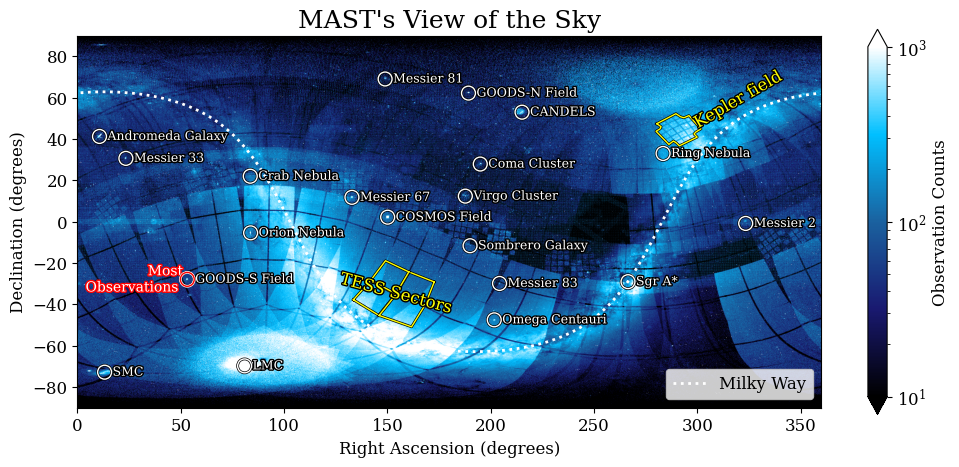

In [12]:
# Initiate plot
plt.figure(figsize=(12, 5))

# Make the background of the plot black
plt.axvspan(0, 360, color="k", zorder=-1)

# Define a custom color map
# This will create a gradient from black to blue to white!
colormap = LinearSegmentedColormap.from_list(
    "", ["black", "midnightblue", "#1a619f", "deepskyblue", "white"]
)

# Plot the data
im = plt.imshow(
    observation_counts.T,
    cmap=colormap,  # Set colormap
    norm=LogNorm(10, 1e3),  # Define limits of colormap
    extent=[0, 360, -90, 90],  # Set the limits of the data
    origin="lower",
)

plt.colorbar(im, label="Observation Counts", extend="both")

# Add annotations using our function above
add_annotations()

# Set axes limits
plt.xlim(0, 360)
plt.ylim(-90, 90)

# Add labels to plot
plt.title("MAST's View of the Sky")
plt.xlabel("Right Ascension (degrees)")
plt.ylabel("Declination (degrees)")

plt.show()

With these annotations, we can more clearly understand different parts of this plot!!

- Some aspects of this plot reflect what we can see in the sky - the disk of the Milky Way is the "U"-shaped stripe across the image. Some of our closest neighbor galaxies, like the Large Magellanic Cloud (LMC) and Small Magellanic Cloud (SMC) are visible near the bottom-left of the image!
- The large rectangles that are most obvious along the lower half of the image are [TESS Sectors](https://tess.mit.edu/observations/)! The TESS telescope has a huge field of view, and observes giant rectangles that are 24° x 96° in size at a time.
- The "+" shaped footprint in the upper-right that that is highlighted in yellow is the [footprint of the Kepler telescope](https://archive.stsci.edu/missions-and-data/kepler), [explain here]. You can also see fainter footprints near the equator, which are all from [the second Kepler Mission (K2)](https://archive.stsci.edu/missions-and-data/k2)
- Some big programs from HST and JWST show up as really bright spots in this image too. The most obvious ones here are the [CANDELS](https://archive.stsci.edu/hlsp/candels) and [COSMOS](https://archive.stsci.edu/prepds/cosmos/) fields, which were two of the largest observing programs done by HST.

But in general, the bright spots peppered around all throughout the image are the locations of many interesting astronomical targets, from nebulaes like the Orion Nebula to galaxies like Andromeda or M81. The brightest points in this image are locations that scientists observe again and again and again, with different telescopes and instruments and at different times - the most interesting parts of the sky!

## Projecting to Different Coordinate Systems

So far, we have made plots using the standard Celestial Coordinate system, using right ascension (RA) and declination (Dec). This is not the only coordinate system used in astronomy, however! Different applications might require different coordinate systems: while the standard celestial coordinate system is centered on the Earth, Ecliptic Coordinates are centered on the ecliptic plane, Earth's orbit around the Sun.

Using [astropy.coordinates](https://docs.astropy.org/en/stable/coordinates/index.html), it is pretty easy to reproject all of our MAST data into another frame. All of the [available coordinate systems are listed here](https://docs.astropy.org/en/stable/coordinates/index.html#module-astropy.coordinates.builtin_frames), but we will explore two in particular: `geocentricmeanecliptic` and `galactic`!

### Ecliptic Coordinates

As a quick refresher, MAST uses coordinates aligned to the celestial pole, which is aligned to our rotating Earth. A declination of +90 is directly overhead the north pole, while -90 is directly overhead the south pole. Our first transformation is to the ecliptic plane, aligned instead to Earth's orbit around the sun:

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Earths_orbit_and_ecliptic.svg/1024px-Earths_orbit_and_ecliptic.svg.png?20241205045923" alt="A diagram showing how the ecliptic plane is defined" width="300px"><br>
<small>By <a href="//commons.wikimedia.org/wiki/User:CielProfond" title="User:CielProfond">CielProfond</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=156276169">Source</a></small>
</center>


Ecliptic coordinates are useful for space-based telescopes, since the sun is — by definition —always at a declination of 0º. In fact, the [survey design of the TESS spacecraft](https://youtu.be/Q4KjvPIbgMI&t=115) takes advantage of this by always keeping one camera on the ecliptic pole, with the others facing opposite the sun.


In [13]:
# Convert from the grid edges into a meshgrid
x, y = np.meshgrid(ra_coords, dec_coords)

# Iniate a SkyCoord object with these coordinates
orig_coords = SkyCoord(x, y, frame="icrs", unit="deg")

# Transform coordinates to Ecliptic Coordinate
coords_ecl = orig_coords.transform_to("geocentricmeanecliptic")
x_ecl = coords_ecl.lon.degree
y_ecl = coords_ecl.lat.degree

Now we can remake our plot in ecliptic coordinates!

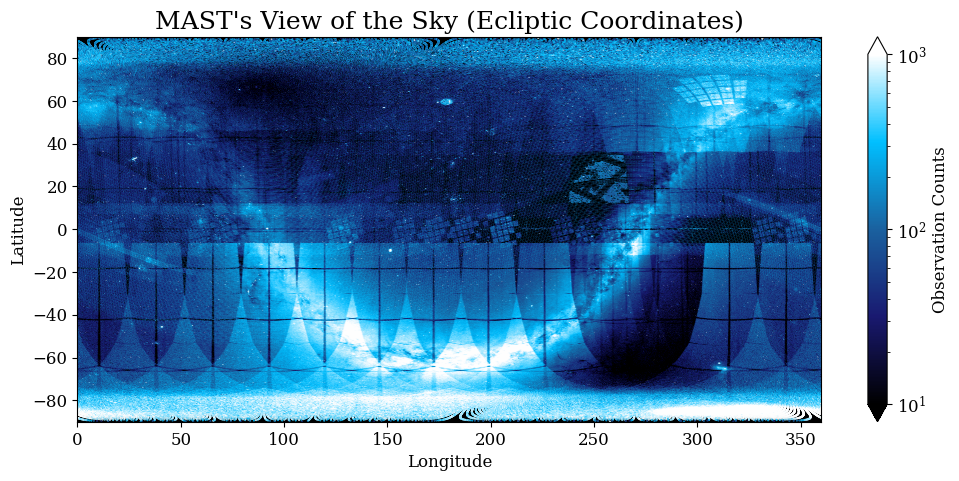

In [14]:
# Initiate plot
plt.figure(figsize=(12, 5))

# Make the background of the plot black
plt.axvspan(0, 360, color="k", zorder=-1)

# Define a custom color map
# This will create a gradient from black to blue to white!
colormap = LinearSegmentedColormap.from_list(
    "", ["black", "midnightblue", "#1a619f", "deepskyblue", "white"]
)


im = plt.scatter(
    x_ecl.flatten(),
    y_ecl.flatten(),
    c=observation_counts.T.flatten(),
    cmap=colormap,  # Set colormap
    norm=LogNorm(10, 1e3),  # Define limits of colormap
    marker=".",
    s=1,
)

plt.colorbar(im, label="Observation Counts", extend="both")


# Set axes limits
plt.xlim(0, 360)
plt.ylim(-90, 90)

# Add labels to plot
plt.title("MAST's View of the Sky (Ecliptic Coordinates)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

### Galactic Coordinates

Somewhat counter-intuitively, galactic coordinates are still centered on our Sun. In this case, 0º longitude is defined to be the line between the sun and the center of the galaxy. Latitude measures the angle of an object relative to the flat disk of the galaxy, as seen from Earth.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/12/Artist%27s_impression_of_the_Milky_Way_%28updated_-_annotated%29.jpg/1200px-Artist%27s_impression_of_the_Milky_Way_%28updated_-_annotated%29.jpg?20130920225409" alt="alt text" width="300px"><br>
<small>By NASA/JPL-Caltech/ESO/R. Hurt - <a rel="nofollow" class="external free" href="http://www.eso.org/public/images/eso1339e/">http://www.eso.org/public/images/eso1339e/</a>, Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=28274906">Source</a></small>
</center>


The nice thing about using the galactic coordinate system is that most stars are near the plane of the galaxy, so it shows up quite nicely on our plot!

In [15]:
# Convert from the grid edges into a meshgrid
x, y = np.meshgrid(ra_coords, dec_coords)

# Iniate a SkyCoord object with these coordinates
orig_coords = SkyCoord(x, y, frame="icrs", unit="deg")

# Transform coordinates to Galactocentric Coordinates
coords_gal = orig_coords.transform_to("galactic")
x_gal = coords_gal.l.wrap_at(180 * units.degree).degree + 180
y_gal = coords_gal.b.degree

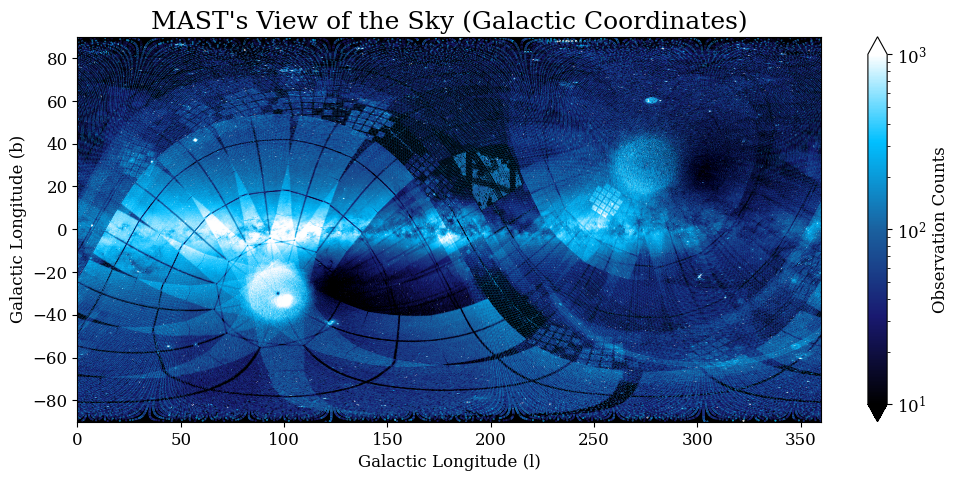

In [16]:
# Initiate plot
plt.figure(figsize=(12, 5))

# Make the background of the plot black
plt.axvspan(0, 360, color="k", zorder=-1)

# Define a custom color map
# This will create a gradient from black to blue to white!
colormap = LinearSegmentedColormap.from_list(
    "", ["black", "midnightblue", "#1a619f", "deepskyblue", "white"]
)

im = plt.scatter(
    x_gal.flatten(),
    y_gal.flatten(),
    c=observation_counts.T.flatten(),
    cmap=colormap,  # Set colormap
    norm=LogNorm(10, 1e3),  # Define limits of colormap
    marker=".",
    s=1,
)

plt.colorbar(im, label="Observation Counts", extend="both")


# Set axes limits
plt.xlim(0, 360)
plt.ylim(-90, 90)

# Add labels to plot
plt.title("MAST's View of the Sky (Galactic Coordinates)")
plt.xlabel("Galactic Longitude (l)")
plt.ylabel("Galactic Longitude (b)")

plt.show()

## Wallpaper Image

Just for fun, let's make a pretty version of this plot to use as a Desktop Wallpaper, removing the axes and labels and focusing on the image.

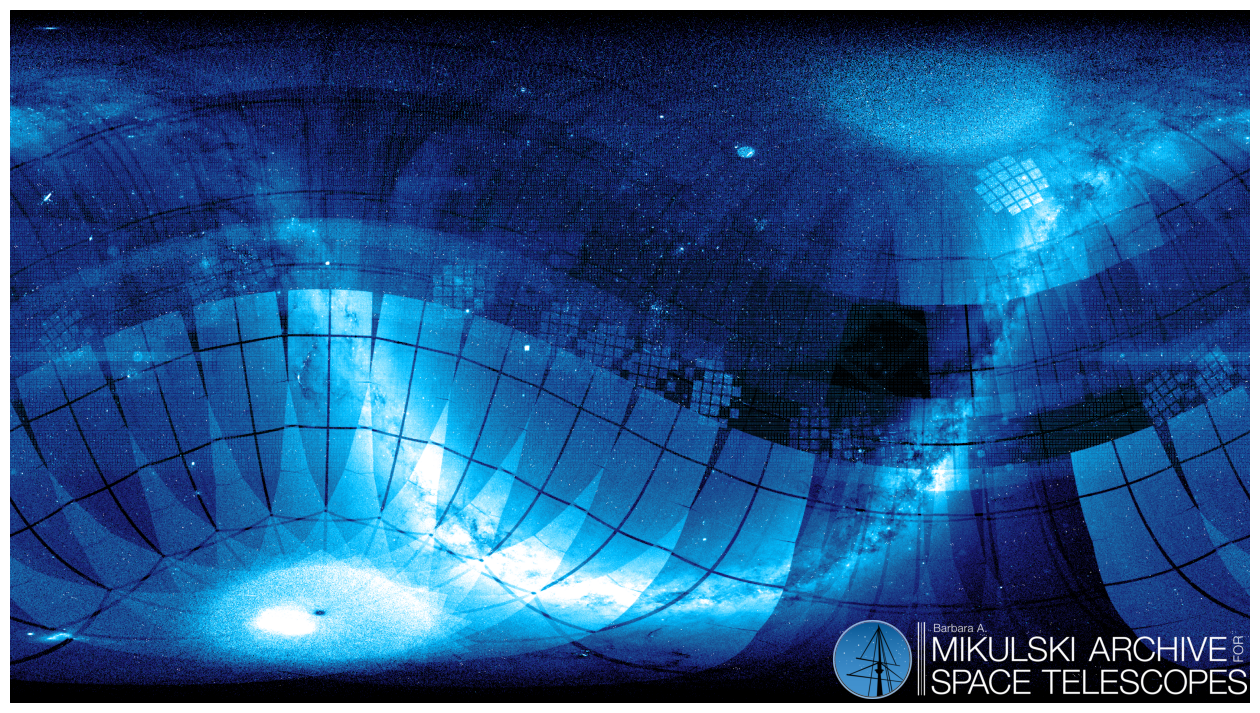

In [17]:
# Initiate plot - 16:9 aspect ratio for wallpaper
plt.figure(figsize=(16, 9))

ax = plt.subplot()

# Make the background of the plot black
plt.style.use("dark_background")
plt.axvspan(0, 360, color="k", zorder=-1)

# Define a custom color map
# This will create a gradient from black to blue to white!
colormap = LinearSegmentedColormap.from_list(
    "", ["black", "midnightblue", "#1a619f", "deepskyblue", "white"]
)

# Plot the data
im = ax.imshow(
    observation_counts.T,
    cmap=colormap,  # Set colormap
    norm=LogNorm(10, 1e3),  # Define limits of colormap
    extent=[0, 360, -90, 90],  # Set the limits of the data
    origin="lower",
)

# Add MAST logo to corner
mast_logo = imread("imgs/MAST-Logo-Horizontal.png")
# preserve aspect ratio so the logo isn't skewed
mast_logo_ratio = mast_logo.shape[0] / mast_logo.shape[1] * (8 / 9)
# Need extra 8/9 because the figure size is 16:9 but the pixel size is 16:8
mast_logo_size = 120  # degrees
ax.imshow(
    mast_logo,
    zorder=100,  # bring to front of plot
    extent=[
        359 - mast_logo_size,
        359,
        -89,
        -89 + mast_logo_size * mast_logo_ratio,
    ],
)

# Set axes limits
plt.xlim(0, 360)
plt.ylim(-90, 90)

# turn off axes
plt.axis("off")
# Force aspect ratio 16:9
ax.set_aspect("auto")

# Save file
plt.savefig("mast_wallpaper.png", bbox_inches="tight", dpi=300)

plt.savefig("mast_visualization.png", bbox_inches="tight")
plt.show()

Nice! Just for fun, we can make this image again in different colors. Try out any colormap you want - [all of the colormaps available in Python are listed here](https://matplotlib.org/stable/users/explain/colors/colormaps.html)!

In [18]:
colormap = "magma"

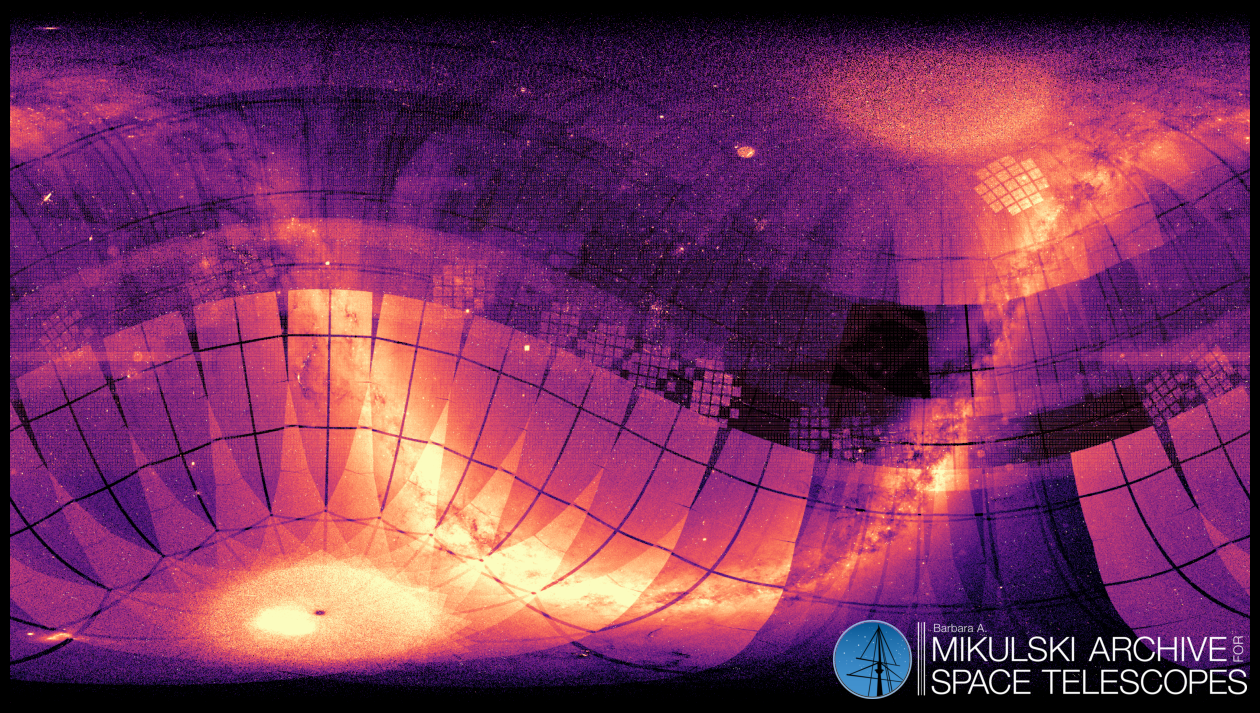

In [19]:
# Initiate plot - 16:9 aspect ratio for wallpaper
plt.figure(figsize=(16, 9))

ax = plt.subplot()

# Make the background of the plot black
plt.style.use("dark_background")
plt.axvspan(0, 360, color="k", zorder=-1)

# Plot the data
im = ax.imshow(
    observation_counts.T,
    cmap=colormap,  # Set colormap
    norm=LogNorm(10, 1e3),  # Define limits of colormap
    extent=[0, 360, -90, 90],  # Set the limits of the data
    origin="lower",
)


# Add MAST logo to corner
mast_logo = imread("imgs/MAST-Logo-Horizontal.png")
# preserve aspect ratio so the logo isn't skewed
mast_logo_ratio = mast_logo.shape[0] / mast_logo.shape[1] * (8 / 9)
# Need extra 8/9 because the figure size is 16:9 but the pixel size is 16:8
mast_logo_size = 120  # degrees
ax.imshow(
    mast_logo,
    zorder=100,  # bring to front of plot
    extent=[
        359 - mast_logo_size,
        359,
        -89,
        -89 + mast_logo_size * mast_logo_ratio,
    ],
)

# Set axes limits
plt.xlim(0, 360)
plt.ylim(-90, 90)

# turn off axes
plt.axis("off")
# Force aspect ratio 16:9
ax.set_aspect("auto")

# Save file
plt.savefig("mast_wallpaper2.png", bbox_inches="tight", dpi=300)

plt.show()

## Additional Resources

Additional resources are linked below:

- [MAST Home Page](https://archive.stsci.edu)
- [About MAST](https://archive.stsci.edu/about-mast)
- [MAST Helpdesk](https://outerspace.stsci.edu/display/MASTDOCS/Archive+Support)

### Citations

If you use this visualization for published work, see the following links for information on which citations to include:

* [Citing MAST](https://archive.stsci.edu/publishing/mission-acknowledgements)
* [Citing astropy](https://www.astropy.org/acknowledging.html)


### About this Notebook

**Authors:** Julie Imig (jimig@stsci.edu), Thomas Dutkiewicz (tdutkiewicz@stsci.edu)<br>
**Keywords:** Tutorial, MAST, data visualization <br>
**First published:** July 2025 <br>
**Last updated:** July 2025 <br>

***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/style-guides/master/guides/images/stsci-logo.png" alt="Space Telescope Logo" width="200px"/> 